In [16]:
import pyiast
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import time
import os
import scipy.optimize as optim
import matplotlib.pyplot as plt

In [18]:

df_NAME=pd.read_csv("HEAT_0215.csv")

bins_CO2 = []
for nam in df_NAME["NAME"]:
    f_tmp = open("iso_"+nam+"_saved.bin",'rb')
    bin_tmp = pickle.load(f_tmp)
    bins_CO2.append(bin_tmp)
    f_tmp.close()

Names_CO2=df_NAME["NAME"].to_numpy()

dH_CO2 = np.array([df_NAME["CH4_Heat"],df_NAME["H2S_Heat"],df_NAME["CO2_Heat"]]).T

print(Names_CO2)


['ACO_0' 'AEI_0' 'AEI_1' 'AEL_0' 'AEL_1' 'AEL_2' 'AET_0' 'AET_1' 'AFI_0'
 'AFI_1' 'AFN_0' 'AFO_0' 'AFO_1' 'AFR_0' 'AFR_1' 'AFS_0' 'AFS_1' 'AFT_0'
 'AFT_1' 'AFV' 'AFX_0' 'AFX_1' 'AFY_0' 'AHT_1' 'APC_1' 'APC_2' 'APD_0'
 'ASV_0' 'ATN_0' 'ATN_1' 'ATO_0' 'ATO_1' 'ATS_0' 'ATS_1' 'ATT_0' 'ATT_1'
 'ATV_0' 'AVE' 'AVL' 'AWO_0' 'AWO_1' 'AWW_0' 'BEA_0' 'BEA_1' 'BEA_B_1'
 'BEC_0' 'BEC_2' 'BOF_0' 'BOG_0' 'BOG_1' 'BOZ_0' 'BPH_0' 'BRE_1' 'BSV_0'
 'CAN_0' 'CAN_1' 'CDO_0' 'CDO_1' 'CFI_0' 'CFI_1' 'CGF_0' 'CGS_0' 'CHA_0'
 'CLO_0' 'CON_0' 'CON_1' 'CON_2' 'CSV' 'CZP_0' 'DAC_0' 'DDR_0' 'DDR_1'
 'DFO_0' 'DFO_1' 'DFT_0' 'DON_0' 'DON_1' 'EAB_0' 'EAB_1' 'EAB_2' 'EDI_0'
 'EDI_2' 'EMT_0' 'EMT_1' 'EMT_2' 'EON_0' 'EON_1' 'EPI_0' 'EPI_1' 'ERI_0'
 'ERI_1' 'ERI_2' 'ESV_0' 'ESV_1' 'ETL' 'ETR_0' 'ETR_1' 'EUO_0' 'EUO_1'
 'EWS' 'EZT_0' 'EZT_1' 'FAU_0' 'FAU_1' 'FAU_2' 'FAU_3' 'FAU_4' 'FAU_5'
 'FAU_6' 'FER_0' 'FER_1' 'FER_2' 'GIS_0' 'GIS_1' 'GIS_2' 'GIS_3' 'GIS_4'
 'GIS_5' 'GIS_6' 'GME_0' 'GME_1' 'GON_0' 'GON_1' 'GOO_0' 'HEU

In [19]:
Arrh = lambda T,dH ,T_ref: np.exp(-dH/8.3145*(1/T - 1/T_ref)) # Arrhenius equation (Clasius-Clapeyron Equation)

## Isothermal mixture isotherm
def iso_mix(P_par, T, iso_list, dH_list,Tref_list):
    P_norm = []
    for (p,dh,tref) in zip(P_par, dH_list,Tref_list):
        p_n = Arrh(T,dh,tref)*p 
        P_norm.append(p_n)
    P_norm_arr = np.array(P_norm)
    #print(P_norm_mat.T)
    if P_norm_arr.ndim > 1:
        for i in range(len(P_norm[0])):
            p_tmp = P_norm_arr[i,:]
            p_tmp[p_tmp<0.000001] = 0.000001
            q_IAST_tmp = pyiast.iast(p_tmp,
                                     iso_list,
                                     warningoff=True)
    else:
        try:
            p_tmp = P_norm_arr
            p_tmp[p_tmp<0.000001] = 0.000001
            #print(p_tmp)
            q_IAST_tmp = pyiast.iast(p_tmp,
                                    iso_list,
                                     warningoff=True)
        except:    
            try:
                #print('Initial guess error with P = ',P_par)
                x_IG = np.ones(len(p_tmp))/len(p_tmp)
                q_IAST_tmp = pyiast.iast(p_tmp,
                                        iso_list,adsorbed_mole_fraction_guess = x_IG,
                                        warningoff=True)
            except:
                try:
                    arg_min = np.argmin(p_tmp)
                    p_tmp[p_tmp<0.000001] = 0.000001
                    x_IG = 0.05*np.ones(len(p_tmp))
                    x_IG[arg_min] = 1 - 0.05*(len(p_tmp)-1)
                    #print(x_IG)
                    q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                except:
                    try:
                        arg_max = np.argmax(p_tmp)
                        p_tmp[p_tmp<0.000001] = 0.000001
                        x_IG = 0.05*np.ones(len(p_tmp))
                        x_IG[arg_max] = 1 - 0.05*(len(p_tmp)-1)
                        #print(x_IG)
                        q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)        
                    except:
                        try:
                            arg_max = np.argmax(p_tmp)
                            p_tmp[p_tmp<0.000001] = 0.000001
                            x_IG = 0.15*np.ones(len(p_tmp))
                            x_IG[arg_max] = 1 - 0.15*(len(p_tmp)-1)
                            #print(x_IG)
                            q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                                warningoff=True)
                        except:
                            try:
                                arg_min = np.argmin(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_min] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                            iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)

                            except:
                                arg_max = np.argmax(p_tmp)
                                p_tmp[p_tmp<0.000001] = 0.000001
                                x_IG = 0.01*np.ones(len(p_tmp))
                                x_IG[arg_max] = 1 - 0.01*(len(p_tmp)-1)
                                #print(x_IG)
                                q_IAST_tmp = pyiast.iast(p_tmp,
                                                iso_list,adsorbed_mole_fraction_guess = x_IG,
                                            warningoff=True)                                
           
    return q_IAST_tmp

In [20]:
def sat_fraction(y_lead,q_lead_array, y_follow,q_follow_array):
    q_sat_lead_part, q_sat_lead_tot, q_des_lead = q_lead_array
    q_sat_fo, q_des_fo = q_follow_array
    numo = y_follow*(q_sat_lead_part - q_des_lead)+y_lead*q_des_fo
    denom = y_follow*(q_sat_lead_part - q_sat_lead_tot)+y_lead*q_sat_fo
    sat_frac = numo/denom
    return sat_frac

In [21]:
def x2x(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    iso_1 = iso_input[2] # CH4
    iso_2 = iso_input[0] # H2S
    iso_3 = iso_input[1] # CO2
    iso  = [iso_1,iso_2,iso_3]
    dH_1, dH_2, dH_3 = dH_input[:3]         # (kJ/mol): Heat of adsorption
    dH = np.array([dH_1,dH_2,dH_3])*1000    # (J/mol): Heat of adsorption 
    P_low_part = np.array(x_ini)*P_low      # (bar): partial pressure
    P_high_part = np.array(yfeed)*P_high    # (bar): partial pressure
    ### Uptakes
    q_des = iso_mix(P_low_part,Tfeed,iso,
                    dH_input,Tref_input)
    q_sat_tot = iso_mix(P_high_part,Tfeed,iso,
                        dH_input,Tref_input)
    Dq_tot = q_sat_tot-q_des
    ### Leading component ?
    sat_extent = np.array(yfeed)/Dq_tot # Saturation extent kg/mol
    ind_lead_tot = np.argmax(sat_extent)
    sat_ext_raff = sat_extent[0]
    sat_extent[0] = -10000
    ind_lead = np.argmax(sat_extent)

    if ind_lead > 1.95:
        ## CO2 leading case [index = 2]
        yfeed_CO2 = np.array([yfeed[0], yfeed[2]])/(yfeed[0]+yfeed[2])
        P_CO2_part= P_h * yfeed_CO2 # (bar): partial pressure
        q_sat_CO2 = iso_mix(P_CO2_part,Tfeed,[iso[0],iso[2]],
                            [dH[0],dH[2]],[Tref_input[0],Tref_input[2]])
        q_sat_CO2 = np.array([q_sat_CO2[0],0, q_sat_CO2[1]])
        q_lead_pack = [q_sat_CO2[2], q_sat_tot[2], q_des[2]] # CO2 uptakes
        q_follow_pack = [q_sat_tot[1], q_des[1]]
        s_H2S = sat_fraction(yfeed[2],q_lead_pack,yfeed[1],q_follow_pack)
        q_bar_sat = s_H2S*q_sat_tot + (1-s_H2S)*q_sat_CO2
        s = s_H2S
        s_out = np.array([sat_ext_raff/sat_extent[2],s,1])
        leading_heavy_key = 2

    else:
        ## H2S leading case [index = 1]
        yfeed_H2S = np.array([yfeed[0], yfeed[1]])/(yfeed[0]+yfeed[1])
        P_H2S_part= P_h * yfeed_H2S # (bar): partial pressure
        q_sat_H2S = iso_mix(P_H2S_part,Tfeed,[iso[0],iso[1]],
                            [dH[0],dH[1]],[Tref_input[0],Tref_input[1]])
        q_sat_H2S = np.array([q_sat_H2S[0],q_sat_H2S[1],0])
        q_lead_pack = [q_sat_H2S[1],q_sat_tot[1],q_des[1]]
        q_follow_pack = [q_sat_tot[2],q_des[2]]
        s_CO2 = sat_fraction(yfeed[1],q_lead_pack,yfeed[2],q_follow_pack)
        q_bar_sat = s_CO2*q_sat_tot + (1-s_CO2)*q_sat_H2S
        s = s_CO2
        s_out = np.array([sat_ext_raff/sat_extent[1],1,s])
        leading_heavy_key = 1

    Dq_exhaust = q_bar_sat - q_des
    x_out = np.array(Dq_exhaust)/np.sum(Dq_exhaust)
    sat_extent[0] = sat_ext_raff
    return x_out,s_out,ind_lead_tot


In [22]:
def recNx(x_ini,P_high,P_low,
        iso_input, dH_input, Tref_input, 
        yfeed,Tfeed):
    
#    x_exh, s_f,i_lead = x2x(x_ini,P_high,P_low,
#                            iso_input, dH_input, Tref_input, 
#                            yfeed,Tfeed)
    def x_obj(x_in):
        x_exh, s_f,i_lead = x2x(x_in,P_high,P_low,
                                iso_input,dH_input,Tref_input,
                                yfeed,Tfeed)
        return (x_exh-x_in)**2*100
    x00 = x_ini
    solx = optim.least_squares(x_obj,x00,bounds= (0,1))
    x_exh = solx.x
    x_exh, s_f,i_lead = x2x(x_exh,P_high,P_low,
                            iso_input,dH_input,Tref_input,
                            yfeed,Tfeed)
    #for i in range(10):
    #    x_exh, s_f,i_lead = x2x(x_exh,P_high,P_low,
    #                            iso_input, dH_input, Tref_input, 
    #                            yfeed,Tfeed)
    if i_lead == 0:
        if x_exh[1]>x_exh[2]:
            y_hvy = yfeed[1]
            x_hvy = x_exh[1]
        else:
            y_hvy = yfeed[2]
            x_hvy = x_exh[2]
        rec = (1-y_hvy/yfeed[0]*x_exh[0]/x_hvy)*100
        return rec,x_exh,s_f
    else:
        if x_exh[1]>x_exh[2]:
            y_hvy = yfeed[1]
            x_hvy = x_exh[1]
        else:
            y_hvy = yfeed[2]
            x_hvy = x_exh[2]
        rec = (1-y_hvy/yfeed[0]*x_exh[0]/x_hvy)*100
        return -i_lead*10,x_exh,s_f



In [23]:
bins_zeo_CH4_lead = []
bins_zeo_H2S_lead = []
bins_zeo_CO2_lead = []

Names_zeo_CH4_lead = []
Names_zeo_H2S_lead = []
Names_zeo_CO2_lead = []

dH_zeo_CH4_lead = []
dH_zeo_H2S_lead = []
dH_zeo_CO2_lead = []

sf_zeo_CH4 = []
sf_zeo_H2S = []
sf_zeo_CO2 = []
# TEST
x_guess = [0.9, 0.05, 0.05]
y_feed_in = [0.8, 0.05, 0.15]
T_feed_in = 298
P_h = 10
P_l = 1
T_tri = [298, ]*3

for iso, nam, dH in zip(bins_CO2, Names_CO2, dH_CO2):
    rec_tmp, x_tmp, sf_tmp = recNx(
        x_guess, P_h, P_l, iso, dH, T_tri, y_feed_in, T_feed_in)
    print(nam)
    if rec_tmp > 0:
        bins_zeo_CH4_lead.append(iso)
        Names_zeo_CH4_lead.append(nam)
        dH_zeo_CH4_lead.append(dH)
        sf_zeo_CH4.append(sf_tmp)
        continue
    if rec_tmp < -19:
        bins_zeo_CO2_lead.append(iso)
        Names_zeo_CO2_lead.append(nam)
        dH_zeo_CO2_lead.append(dH)
        sf_zeo_CO2.append(sf_tmp)
        continue
    else:
        bins_zeo_H2S_lead.append(iso)
        Names_zeo_H2S_lead.append(nam)
        dH_zeo_H2S_lead.append(dH)
        sf_zeo_H2S.append(sf_tmp)
        continue


print(len(bins_zeo_CH4_lead))
print(len(bins_zeo_H2S_lead))
print(len(bins_zeo_CO2_lead))

ACO_0
AEI_0
AEI_1
AEL_0
AEL_1
AEL_2
AET_0
AET_1
AFI_0
AFI_1
AFN_0
AFO_0
AFO_1
AFR_0
AFR_1
AFS_0
AFS_1
AFT_0
AFT_1
AFV
AFX_0
AFX_1
AFY_0
AHT_1
APC_1
APC_2
APD_0
ASV_0
ATN_0
ATN_1
ATO_0
ATO_1
ATS_0
ATS_1
ATT_0
ATT_1
ATV_0
AVE
AVL
AWO_0
AWO_1
AWW_0
BEA_0
BEA_1
BEA_B_1
BEC_0
BEC_2
BOF_0
BOG_0
BOG_1
BOZ_0
BPH_0
BRE_1
BSV_0
CAN_0
CAN_1
CDO_0
CDO_1
CFI_0
CFI_1
CGF_0
CGS_0
CHA_0
CLO_0
CON_0
CON_1
CON_2
CSV
CZP_0
DAC_0
DDR_0
DDR_1
DFO_0

C:\Users\LeBlanc\anaconda3\pyiast\isotherms.py:354: RuntimeWarning: invalid value encountered in log
  return self.params["M"] * np.log(1.0 + self.params["Ka"] * pressure



DFO_1
DFT_0
DON_0
DON_1
EAB_0
EAB_1
EAB_2
EDI_0
EDI_2
EMT_0
EMT_1
EMT_2
EON_0
EON_1
EPI_0
EPI_1
ERI_0
ERI_1
ERI_2
ESV_0
ESV_1
ETL
ETR_0
ETR_1
EUO_0
EUO_1
EWS
EZT_0
EZT_1
FAU_0
FAU_1
FAU_2
FAU_3
FAU_4
FAU_5
FAU_6
FER_0
FER_1
FER_2
GIS_0
GIS_1
GIS_2
GIS_3
GIS_4
GIS_5
GIS_6
GME_0
GME_1
GON_0
GON_1
GOO_0
HEU_0
HEU_1
HEU_2
IFO_0
IFO_1
IFR_0
IFR_1
IFT
IFU
IFW
IFY
IHW_0
IHW_1
IMF_0
IMF_1
IRN
IRR_0
IRR_1
IRY
ISV_0
ISV_1
ITE_0
ITE_1
ITG
ITH_0
ITH_1
ITR_0
ITR_1
ITT_0
ITV_0
ITW_0
ITW_1
IWR_0
IWR_1
IWS_0
IWS_1
IWV_0
IWV_1
IWW_0
IWW_1
JBW_0
JOZ_0
JRY_0
JSN_0
JSN_1
JSR_0
JST_0
KFI_0
KFI_1
LAU_0
LAU_1
LAU_2
LEV_0
LEV_1
LEV_2
LOV_0
LTA_0
LTA_1
LTA_2
LTF_0
LTF_1
LTL_0
LTL_1
LTL_2
MAZ_0
MAZ_1
MEI_0
MEI_1
MEL_0
MEL_1
MEL_2
MER_0
MER_1
MER_2
MFI_0
MFI_1
MFI_2
MFS_0
MFS_1
MON_0
MOR_0
MOR_1
MOZ_0
MOZ_1
MRE_0
MRE_1
MRT
MSE_0
MSE_1
MTF_0
MTF_1
MTT_0
MTT_1
MTW_0
MTW_1
MWF
MWW_0
MWW_1
NAT_0
NES_0
NES_1
NPT_0
OBW_0
OFF_0
OFF_1
OFF_2
OKO_0
OKO_1
OSI_0
OSI_1
OSO_0
OSO_1
OWE_0
PAU_0
PAU_1
PCR_0
PCR_1
PHI_0
PHI_1
P

In [24]:
for n in Names_zeo_H2S_lead:
    print(n)

AEI_1
AEL_0
AET_0
AET_1
AFI_0
AFI_1
AFN_0
AFO_0
AFR_0
AFR_1
AFS_0
AFS_1
AFT_0
AFT_1
AFV
AFX_0
AFX_1
AFY_0
ATN_0
ATN_1
ATO_0
ATO_1
ATS_0
ATS_1
ATT_1
AVE
AVL
AWW_0
BEA_0
BEA_1
BEA_B_1
BEC_0
BEC_2
BOG_0
BOG_1
BOZ_0
BPH_0
BRE_1
CAN_0
CDO_0
CFI_0
CFI_1
CGS_0
CHA_0
CLO_0
CON_0
CON_1
CON_2
CSV
DFO_0
DFO_1
DON_0
DON_1
EAB_0
EAB_1
EAB_2
EDI_2
EMT_0
EMT_1
EMT_2
EON_1
ERI_0
ERI_1
ERI_2
ESV_0
ETL
ETR_0
ETR_1
EUO_0
EUO_1
EWS
EZT_0
EZT_1
FAU_0
FAU_1
FAU_2
FAU_3
FAU_4
FAU_5
FAU_6
FER_0
FER_1
GIS_3
GME_0
GME_1
GON_0
GON_1
IFO_0
IFO_1
IFR_0
IFR_1
IFT
IFU
IFW
IFY
IHW_0
IHW_1
IRN
IRR_0
IRR_1
IRY
ISV_0
ISV_1
ITE_0
ITE_1
ITG
ITH_0
ITH_1
ITR_0
ITR_1
ITT_0
ITV_0
ITW_1
IWR_1
IWS_0
IWS_1
IWV_0
IWV_1
IWW_0
IWW_1
JRY_0
JSR_0
JST_0
KFI_0
KFI_1
LAU_0
LAU_1
LAU_2
LEV_0
LEV_1
LEV_2
LTA_0
LTA_1
LTA_2
LTF_0
LTF_1
LTL_0
LTL_1
LTL_2
MAZ_0
MAZ_1
MEI_0
MEI_1
MEL_0
MEL_1
MER_2
MFS_0
MOZ_0
MOZ_1
MRE_0
MRT
MSE_0
MSE_1
MTF_0
MTF_1
MTT_0
MTT_1
MTW_0
MTW_1
MWW_0
MWW_1
NAT_0
NES_0
NES_1
NPT_0
OBW_0
OFF_0
OFF_1
OFF_2
OKO_0
OKO_1


In [25]:
for n in Names_zeo_CO2_lead:
    print(n)

ACO_0
AEL_1
AEL_2
AFO_1
AHT_1
APC_2
APD_0
ASV_0
ATT_0
ATV_0
AWO_0
AWO_1
BOF_0
BSV_0
CAN_1
CGF_0
CZP_0
DAC_0
DDR_0
DDR_1
DFT_0
EDI_0
EON_0
EPI_0
EPI_1
ESV_1
FER_2
GIS_0
GIS_1
GIS_2
GIS_4
GIS_5
GIS_6
GOO_0
HEU_0
HEU_1
HEU_2
IMF_0
IMF_1
ITW_0
IWR_0
JOZ_0
JSN_0
JSN_1
LOV_0
MEL_2
MER_0
MER_1
MFI_0
MFI_1
MFI_2
MFS_1
MOR_0
MOR_1
MRE_1
MWF
PAU_0
PAU_1
PCR_0
PCR_1
PHI_1
PON_0
PSI
PWN
PWO
PWW
RHO_0
RON_0
RSN_0
SIV_0
STW_0
SVR_0
SVR_1
SZR_0
SZR_1
THO_0
TON_0
TON_1
UEI_0
UOS_0
VNI_0
WEN_0
YFI


In [62]:
for n in Names_zeo_CH4_lead:
    print(n)

AEI_0
APC_1
CDO_1
JBW_0
MON_0
RRO_0
VSV_0
WEI_0


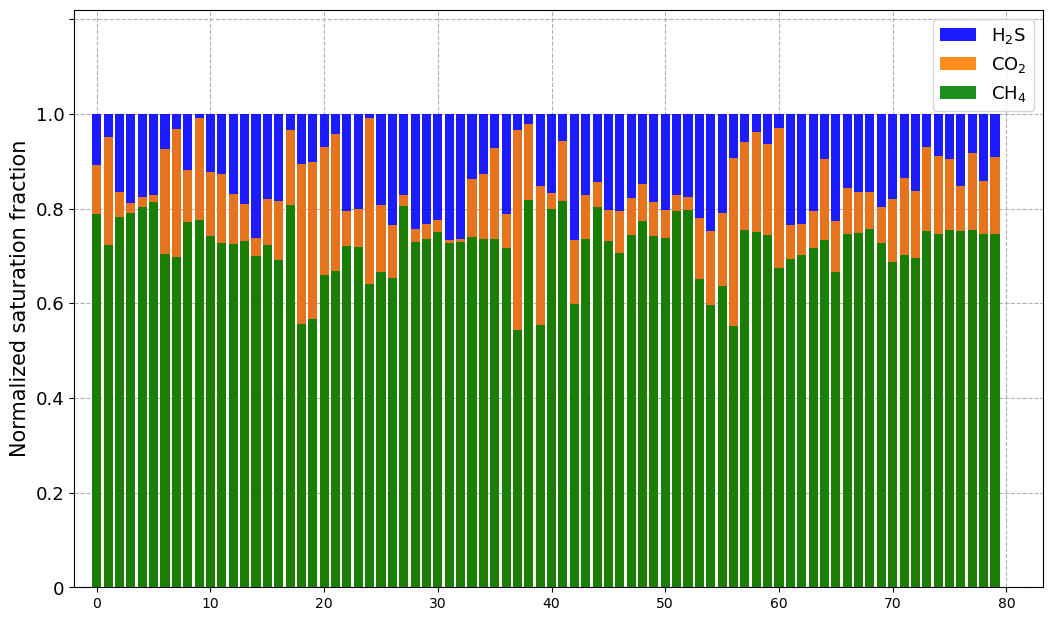

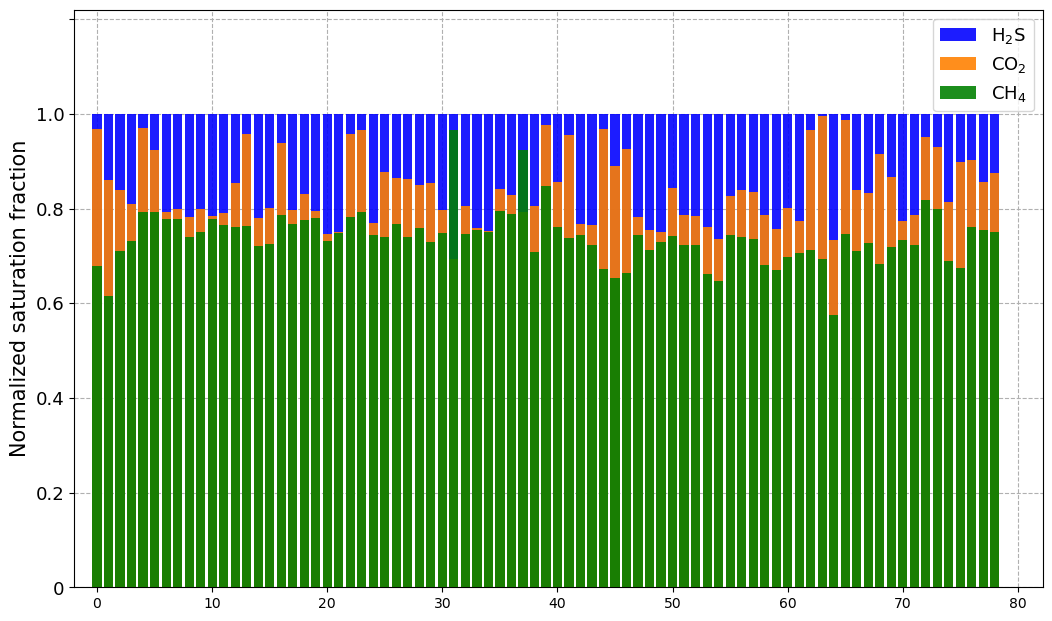

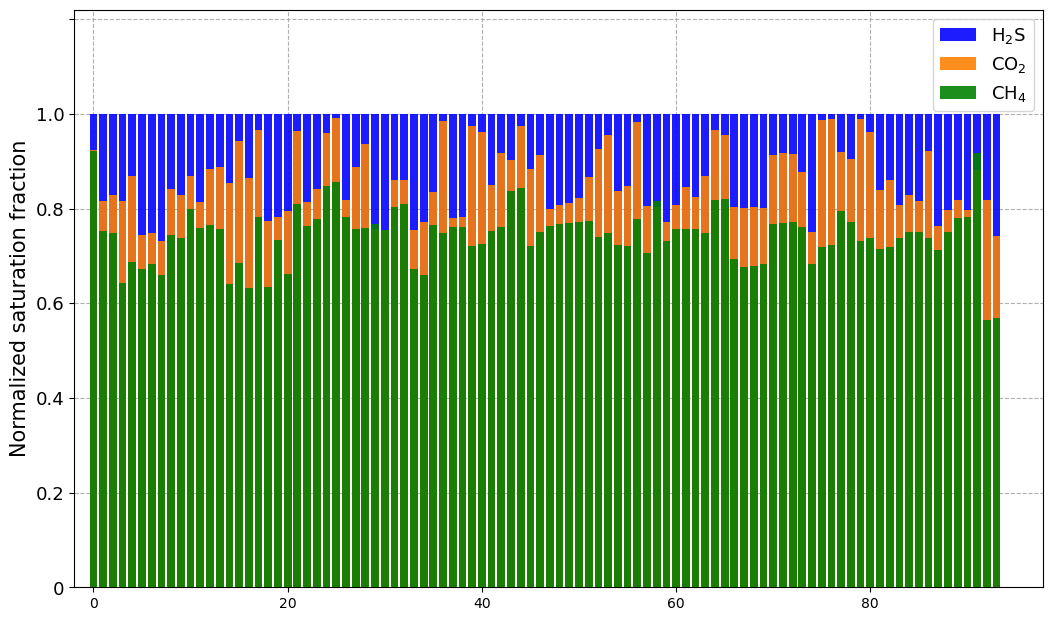

In [10]:
plt.style.use('default')
#plt.style.use('fivethirtyeight')
fig1, ax = plt.subplots(figsize = [12.5, 7.5])
plt.grid(linestyle = '--',)
ax.set_axisbelow(True)
bar1 = ax.bar(np.arange(len(bins_zeo_H2S_lead[:80])), np.array(sf_zeo_H2S[:80])[:,1],
              color = 'b',alpha = 0.89,zorder=1,label='H$_2$S')
bar2 = ax.bar(np.arange(len(bins_zeo_H2S_lead[:80])), np.array(sf_zeo_H2S[:80])[:,2],
              color = [1,0.5,0],alpha = 0.89,zorder=2,label='CO$_2$')
bar3 = ax.bar(np.arange(len(bins_zeo_H2S_lead[:80])), np.array(sf_zeo_H2S[:80])[:,0],
            color = 'g',alpha = 0.89,zorder=3,label='CH$_4$')
#ax.set_xlabel('Adsorbents',fontsize = 15)

#ax.set_xticks(np.arange(0,len(Names_zeo_H2S_lead[:100]),5))
#ax.set_xticklabels(Names_zeo_H2S_lead[::5],fontsize = 13)
ax.set_xlim([-2,len(Names_zeo_H2S_lead[:80])*1.04])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax.set_yticklabels((['0','0.2','0.4','0.6','0.8','1.0']),fontsize = 13)
ax.set_ylim([0,1.22])
ax.set_ylabel('Normalized saturation fraction',fontsize = 15)
ax.legend(fontsize = 13)
fig1.savefig('H2S_leading_case1')


plt.style.use('default')
#plt.style.use('fivethirtyeight')
fig1, ax = plt.subplots(figsize = [12.5, 7.5])
plt.grid(linestyle = '--',)
ax.set_axisbelow(True)
bar1 = ax.bar(np.arange(len(bins_zeo_H2S_lead[81:160])), np.array(sf_zeo_H2S[81:160])[:,1],
              color = 'b',alpha = 0.89,zorder=1,label='H$_2$S')
bar2 = ax.bar(np.arange(len(bins_zeo_H2S_lead[81:160])), np.array(sf_zeo_H2S[81:160])[:,2],
              color = [1,0.5,0],alpha = 0.89,zorder=2,label='CO$_2$')
bar3 = ax.bar(np.arange(len(bins_zeo_H2S_lead[81:160])), np.array(sf_zeo_H2S[81:160])[:,0],
            color = 'g',alpha = 0.89,zorder=3,label='CH$_4$')
#ax.set_xlabel('Adsorbents',fontsize = 15)

#ax.set_xticks(np.arange(0,len(Names_zeo_H2S_lead[:100]),5))
#ax.set_xticklabels(Names_zeo_H2S_lead[::5],fontsize = 13)
ax.set_xlim([-2,len(Names_zeo_H2S_lead[81:160])*1.04])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax.set_yticklabels((['0','0.2','0.4','0.6','0.8','1.0']),fontsize = 13)
ax.set_ylim([0,1.22])
ax.set_ylabel('Normalized saturation fraction',fontsize = 15)
ax.legend(fontsize = 13)
fig1.savefig('H2S_leading_case2')

plt.style.use('default')
#plt.style.use('fivethirtyeight')
fig1, ax = plt.subplots(figsize = [12.5, 7.5])
plt.grid(linestyle = '--',)
ax.set_axisbelow(True)
bar1 = ax.bar(np.arange(len(bins_zeo_H2S_lead[161:])), np.array(sf_zeo_H2S[161:])[:,1],
              color = 'b',alpha = 0.89,zorder=1,label='H$_2$S')
bar2 = ax.bar(np.arange(len(bins_zeo_H2S_lead[161:])), np.array(sf_zeo_H2S[161:])[:,2],
              color = [1,0.5,0],alpha = 0.89,zorder=2,label='CO$_2$')
bar3 = ax.bar(np.arange(len(bins_zeo_H2S_lead[161:])), np.array(sf_zeo_H2S[161:])[:,0],
            color = 'g',alpha = 0.89,zorder=3,label='CH$_4$')
#ax.set_xlabel('Adsorbents',fontsize = 15)

#ax.set_xticks(np.arange(0,len(Names_zeo_H2S_lead[:100]),5))
#ax.set_xticklabels(Names_zeo_H2S_lead[::5],fontsize = 13)
ax.set_xlim([-2,len(Names_zeo_H2S_lead[161:])*1.04])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax.set_yticklabels((['0','0.2','0.4','0.6','0.8','1.0']),fontsize = 13)
ax.set_ylim([0,1.22])
ax.set_ylabel('Normalized saturation fraction',fontsize = 15)
ax.legend(fontsize = 13)
fig1.savefig('H2S_leading_case3')




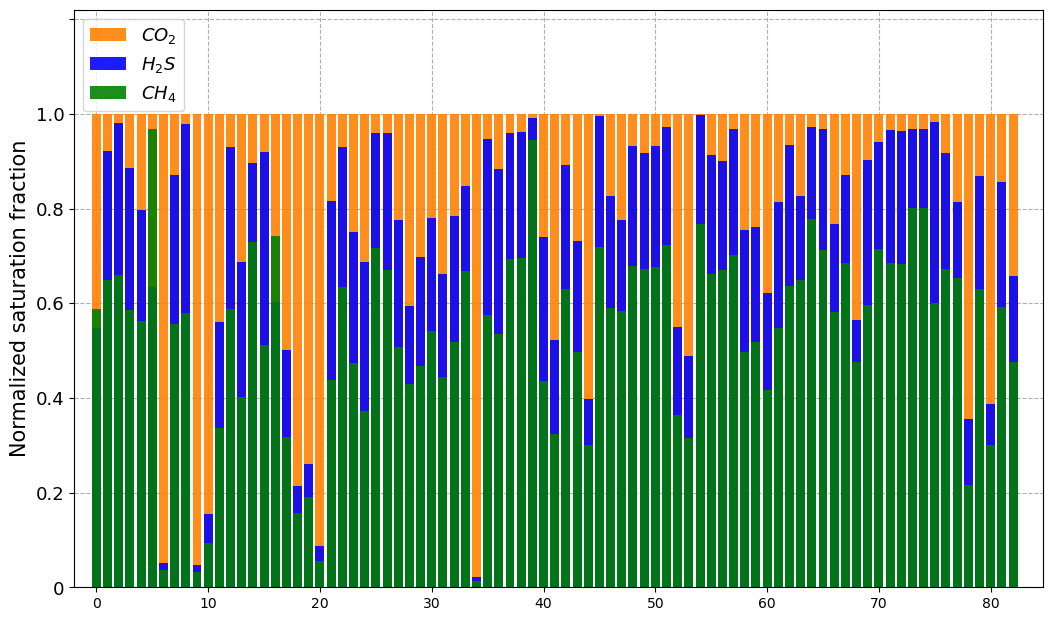

In [11]:
## CO2 leading cases
#plt.style.use('seaborn-darkgrid')
#plt.style.use('fivethirtyeight')
fig2, ax = plt.subplots(figsize = [12.5, 7.5])
plt.grid(linestyle = '--',)
ax.set_axisbelow(True)
bar2 = ax.bar(np.arange(len(bins_zeo_CO2_lead)), np.array(sf_zeo_CO2)[:,2],
              color = [1,0.5,0],alpha = 0.89)
bar1 = ax.bar(np.arange(len(bins_zeo_CO2_lead)), np.array(sf_zeo_CO2)[:,1],
              color = 'b',alpha = 0.89)
bar3 = ax.bar(np.arange(len(bins_zeo_CO2_lead)), np.array(sf_zeo_CO2)[:,0],
              color = 'g',alpha = 0.89)
#ax.set_xlabel('Adsorbents',fontsize = 15)

#ax.set_xticks(np.arange(0,len(Names_zeo_CO2_lead),1))
#ax.set_xticklabels(Names_zeo_CO2_lead[::1],fontsize = 13)
ax.set_xlim([-2.0,len(Names_zeo_CO2_lead)*1.02])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])
ax.set_yticklabels((['0','0.2','0.4','0.6','0.8','1.0']),fontsize = 13)
ax.set_ylim([0,1.22])
ax.set_ylabel('Normalized saturation fraction',fontsize = 15)
ax.legend(['$CO_2$','$H_2S$','$CH_4$'], fontsize = 13,loc=2)
fig2.savefig('CO2_leading_case')


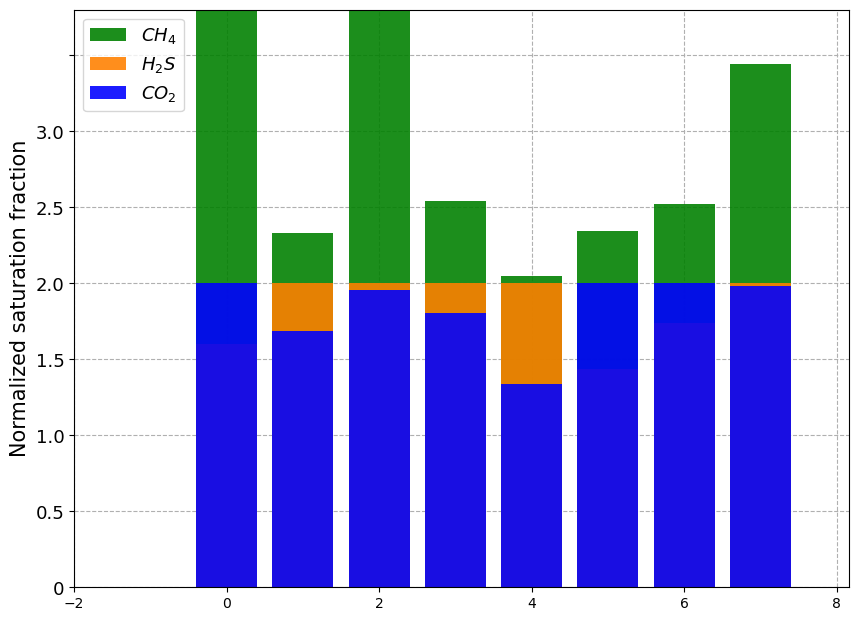

In [14]:
## CH4leading cases
#plt.style.use('seaborn-darkgrid')
#plt.style.use('fivethirtyeight')
fig2, ax = plt.subplots(figsize = [10, 7.5])
plt.grid(linestyle = '--',)
ax.set_axisbelow(True)
bar3 = ax.bar(np.arange(len(bins_zeo_CH4_lead)), np.array(sf_zeo_CH4)[:,0],
                            color = 'g',alpha = 0.89)

bar2 = ax.bar(np.arange(len(bins_zeo_CH4_lead)), np.array(sf_zeo_CH4)[:,2],
              color = [1,0.5,0],alpha = 0.89)
bar1 = ax.bar(np.arange(len(bins_zeo_CH4_lead)), np.array(sf_zeo_CH4)[:,1],
              color = 'b',alpha = 0.89)


#ax.set_xlabel('Adsorbents',fontsize = 15)

#ax.set_xticks(np.arange(0,len(Names_zeo_CO2_lead),1))
#ax.set_xticklabels(Names_zeo_CO2_lead[::1],fontsize = 13)
ax.set_xlim([-2.0,len(Names_zeo_CH4_lead)*1.02])
#ax.set_yticks([0,0.5,1.0,1.5,2.0,2.5,3.0])
ax.set_yticklabels((['0','0.5','1.0','1.5','2.0','2.5','3.0']),fontsize = 13)
ax.set_ylim([0,1.9])
ax.set_ylabel('Normalized saturation fraction',fontsize = 15)
ax.legend(['$CH_4$','$H_2S$','$CO_2$'], fontsize = 13,loc=2)
fig2.savefig('CH4_leading_case1')

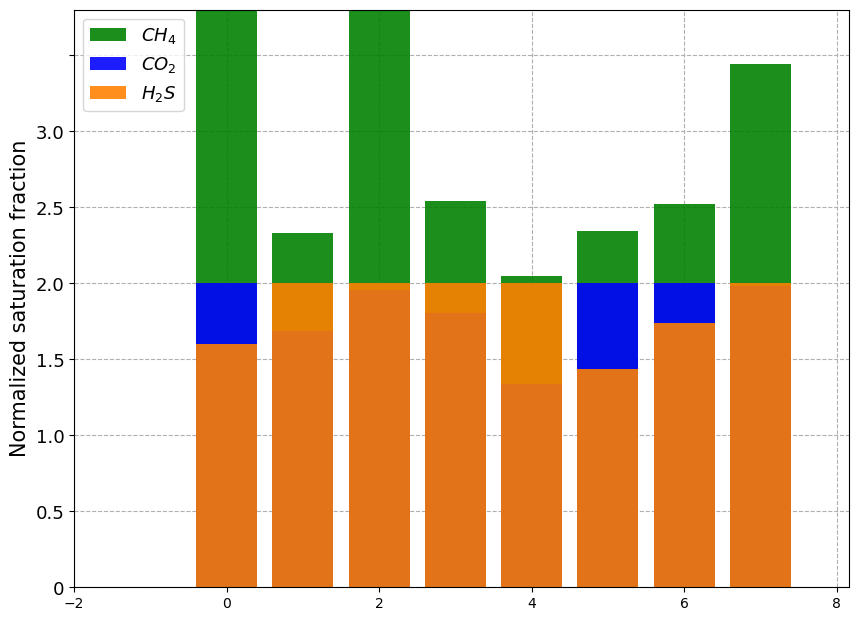

In [15]:
## CH4leading cases2
#plt.style.use('seaborn-darkgrid')
#plt.style.use('fivethirtyeight')
fig2, ax = plt.subplots(figsize = [10, 7.5])
plt.grid(linestyle = '--',)
ax.set_axisbelow(True)
bar3 = ax.bar(np.arange(len(bins_zeo_CH4_lead)), np.array(sf_zeo_CH4)[:,0],
                            color = 'g',alpha = 0.89)

bar2 = ax.bar(np.arange(len(bins_zeo_CH4_lead)), np.array(sf_zeo_CH4)[:,1],
              color = 'b',alpha = 0.89)
bar1 = ax.bar(np.arange(len(bins_zeo_CH4_lead)), np.array(sf_zeo_CH4)[:,2],
              color = [1,0.5,0],alpha = 0.89)


#ax.set_xlabel('Adsorbents',fontsize = 15)

#ax.set_xticks(np.arange(0,len(Names_zeo_CO2_lead),1))
#ax.set_xticklabels(Names_zeo_CO2_lead[::1],fontsize = 13)
ax.set_xlim([-2.0,len(Names_zeo_CH4_lead)*1.02])
#ax.set_yticks([0,0.5,1.0,1.5,2.0,2.5,3.0])
ax.set_yticklabels((['0','0.5','1.0','1.5','2.0','2.5','3.0']),fontsize = 13)
ax.set_ylim([0,1.9])
ax.set_ylabel('Normalized saturation fraction',fontsize = 15)
ax.legend(['$CH_4$','$CO_2$','$H_2S$'], fontsize = 13,loc=2)
fig2.savefig('CH4_leading_case2')

In [17]:
import csv
with open('saturation_H2S.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(sf_zeo_H2S)



In [18]:
with open('saturation_CO2.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(sf_zeo_CO2)



In [19]:
with open('saturation_CH4.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(sf_zeo_CH4)



[[<pyiast.isotherms.ModelIsotherm object at 0x000002C389B0F760>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B46490>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B46A60>], [<pyiast.isotherms.ModelIsotherm object at 0x000002C389B0F850>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B468B0>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B46E50>], [<pyiast.isotherms.ModelIsotherm object at 0x000002C389B0FD60>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B4F550>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B4FAF0>], [<pyiast.isotherms.ModelIsotherm object at 0x000002C389B464C0>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B4F970>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B4FF10>], [<pyiast.isotherms.ModelIsotherm object at 0x000002C389B46910>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B4FD90>, <pyiast.isotherms.ModelIsotherm object at 0x000002C389B6A370>], [<pyiast.isotherms.ModelIsotherm object at 0